-Wave No hergün 1’den başlar

- Ekipman/ personel maliyetin için günlük max toplama miktarı kısıtımız aşağıdaki gibi olacaktır:
01 operasyonu için: 25.000
02 operasyonu için: 175.000

- Sipariş Edilen Tarih < Toplama Tarihi < Sevkiyat Tarihi

In [1]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('chesterish')

In [2]:
import pandas as pd

In [3]:
picking_df = pd.read_csv('data/datathon_picking.csv', index_col='Unnamed: 0')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,5,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
picking_df.head()

,Siparis No,Siparis Tipi,Urun Kodu,Toplanan Miktar,Toplama Tarihi,Toplama Saati,Siparişin Düştüğü Tarih,Sevkiyat Tarihi,Müşteri,Operasyon Numarası
0,72616784,10.0,61000058,45,28122019,11:10,26122019,2012020,C10005,O1
1,72616784,10.0,61000058,45,28122019,11:11,26122019,2012020,C10005,O1
2,72616784,10.0,61000058,45,28122019,11:11,26122019,2012020,C10005,O1
3,72616784,10.0,61000058,45,28122019,11:12,26122019,2012020,C10005,O1
4,72616784,10.0,61000058,45,28122019,11:10,26122019,2012020,C10005,O1


In [5]:
picking_df.columns = ['order_num', 'order_type', 'material_num', 'order_amount', 'picking_date', 
                      'picking_hour', 'order_receive_date', 'shipping_date', 'customer_num', 'operation_type']

In [6]:
# from analysis we saw that customer number 'C-10170' is replaced with 'C-10277', so we replace all the values
picking_df.replace('C-10170', 'C-10277', inplace=True)

In [7]:
picking_df.head()

,order_num,order_type,material_num,order_amount,picking_date,picking_hour,order_receive_date,shipping_date,customer_num,operation_type
0,72616784,10.0,61000058,45,28122019,11:10,26122019,2012020,C10005,O1
1,72616784,10.0,61000058,45,28122019,11:11,26122019,2012020,C10005,O1
2,72616784,10.0,61000058,45,28122019,11:11,26122019,2012020,C10005,O1
3,72616784,10.0,61000058,45,28122019,11:12,26122019,2012020,C10005,O1
4,72616784,10.0,61000058,45,28122019,11:10,26122019,2012020,C10005,O1


In [8]:
def convert_string_to_date(str_date):
    
    str_date = str(str_date)
    str_date = str_date.replace('/','')
    str_date = str_date.replace('.','')
    
    len_date = len(str_date)
    
    if len_date>7:
        return pd.Timestamp(int(str_date[4:]), int(str_date[2:4]), int(str_date[:2]))   
    elif len_date==7:
        return pd.Timestamp(int(str_date[3:]), int(str_date[1:3]), int(str_date[:1]))   
    elif len_date==6:
        return pd.Timestamp(int(str_date[2:]), int(str_date[1:2]), int(str_date[:1]))   

In [9]:
picking_df['picking_date'] = picking_df['picking_date'].apply(convert_string_to_date)
picking_df['order_receive_date'] = picking_df['order_receive_date'].apply(convert_string_to_date)
picking_df['shipping_date'] = picking_df['shipping_date'].apply(convert_string_to_date)
picking_df['picking_hour'] = pd.to_datetime(picking_df['picking_hour'])

In [10]:
picking_df.shape

(712390, 10)

In [11]:
picking_df['time_for_shipping'] = (picking_df['shipping_date'] - picking_df['order_receive_date']).dt.days

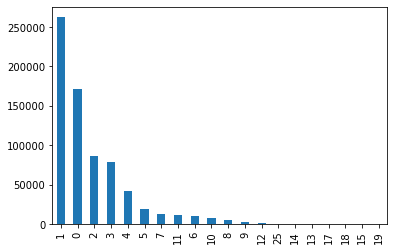

In [12]:
picking_df['time_for_shipping'].value_counts().plot(kind='bar')

In [13]:
avg_prod_shipping = pd.DataFrame()
avg_prod_shipping['avg_shipping_time'] = picking_df.groupby('material_num').agg({'time_for_shipping':'mean'})['time_for_shipping']
avg_prod_shipping['shipping_count'] = picking_df.groupby('material_num').agg({'time_for_shipping':'count'})['time_for_shipping']
avg_prod_shipping = avg_prod_shipping.sort_values('avg_shipping_time').reset_index()
avg_prod_shipping.query('avg_shipping_time == 0 and shipping_count > 10')
# orders for below products are immediate

,material_num,avg_shipping_time,shipping_count
2,PL07872A,0.0,54
5,TR00818B,0.0,13
14,TR02034B,0.0,17
19,CN06559A,0.0,13
22,61010324,0.0,29


In [14]:
avg_cust_shipping = pd.DataFrame()
avg_cust_shipping['avg_shipping_time'] = picking_df.groupby('customer_num').agg({'time_for_shipping':'mean'})['time_for_shipping']
avg_cust_shipping['shipping_count'] = picking_df.groupby('customer_num').agg({'time_for_shipping':'count'})['time_for_shipping']
avg_cust_shipping = avg_cust_shipping.sort_values('avg_shipping_time').reset_index()
avg_cust_shipping.query('avg_shipping_time == 0 and shipping_count > 10')
# below customers give their orders immediate, same day shipping

,customer_num,avg_shipping_time,shipping_count
0,M982,0.0,32
2,M788,0.0,13
4,C10282,0.0,51
6,C10244,0.0,36
7,M597,0.0,20
10,M961,0.0,28
12,M147,0.0,11
13,M98,0.0,45
18,M449,0.0,17


## assumptions 

toplama algoritması:
    her bir gün için 
        1. verileri kullanarak o gün gelen siparişleri ve varsa henüz teslim tarihi gelmemiş eski siparişleri checkliste ekler
        2. checklistte o gün teslim edilmesi gereken siparişler must_pick listesine eklenir. 
        3. must_pick listesi günlük kapasiteye kadar normal olarak toplanır günlük kapasitenin üzerindeki toplama işlemleri ise overwork olarak gerçekleştirilir. (yani o gün teslim edilmese gereken siparişlerin tamamı kapasite içinde eğer yetmezse overwork olarak toplanacağı varsayılmıştır.)
        4. must_pick listesi toplandıktan sonra eğer wavede boş yer kaldıysa ve günlük toplama kısıtı aşılmadıysa ek toplama işlemi yapılır
            wave'i efektif kullanmak adına checklistte bulunan aynı koddaki materyaller kısıtları aşmayacak şekilde toplanmaya çalışılır
            aynı materyaller toplandıktan sonra hala yer kaldıysa, checklistte bulunan en yakın teslim edilmesi gerekenden uzağa doğru ürünler sıralanarak shipping date inden önce yeni sipariş gelip gelmeyeceği predictionlar kullanılarak kontrol edilir ve eğer ürün gelmesi planlanmıyorsa toplanır. (Burada yeni siparişin gelmesi durumunda gelecek tarihte o ürün için tekrar toplama işlemi yapılacağından wave sayısını minimize etmek açısından erken toplama yapılmamıştır. Eğer yeni sipariş gelmesi beklenmiyorsa toplama işlemi kısıtlar dahilinde gerçekleştirilmiştir.)
       
        5. dolmamış herhangi bir wave bulunmuyor ise ve günlük kısıt hala doldurulmadıysa gelecek tarihlerde bir darboğaz(bottleneck) olup olmadığı kontrol edilir. Darboğaz yaşanacak ise günlük kısıtlar dahilinde toplama işlemi yapılır. Eğer darboğaz öngörülmüyorsa toplama işlemi wave'i minimize etmek açısından yapılmamıştır.
        
        
        
    

0. toplanması gereken miktarlar için 'Toplanan Miktar' sütunu baz alınmıştır
1. all orders will be ready for shipping at the end of shipping date (ex: 6 pm)
2. all orders are recieved at the beginning of receive date
3. picking is done asap to be able to meet unexpected orders
4. we can pick orders for next days to utilize waves more
5. different orders can be picked in one wave and one order can be picked by different waves. packing operation handles the 
6. one item in an order cannot be splitted and cannot be put in different waves
7. tahminler ne kadar iyi de olsa güvenilmez olduğu için sadece tahminlere göre topla/toplama kararı verilmiş, kesin siparişler harici toplama yapılmamıştır. ve tahminler olabildiğince az kullanılmaya çalışılmıştır.
8. toplama algoritmamızın daha efektif çalıştığını görebilmek adına gelecek tahminler var olan datadan elde edilmiştir.

## to do

1. only meet the constraints
2. add the future orders as predictions
3. balance the workload, not 10,1,3,22 waves for 4 days, should be 8,9,9,10
4. minimize the workload for sunday
5. add holidays

In [15]:
df = picking_df[['order_num', 'material_num', 'order_receive_date', 'shipping_date',
                 'customer_num', 'operation_type', 'order_amount']].copy()

In [16]:
df.sort_values(by=['order_receive_date', 'order_num'], inplace=True)

In [17]:
df.head()

,order_num,material_num,order_receive_date,shipping_date,customer_num,operation_type,order_amount
0,72616784,61000058,2019-12-26,2020-01-02,C10005,O1,45
1,72616784,61000058,2019-12-26,2020-01-02,C10005,O1,45
2,72616784,61000058,2019-12-26,2020-01-02,C10005,O1,45
3,72616784,61000058,2019-12-26,2020-01-02,C10005,O1,45
4,72616784,61000058,2019-12-26,2020-01-02,C10005,O1,45


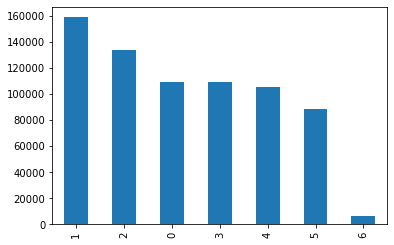

In [18]:
df['shipping_date'].dt.weekday.value_counts().plot(kind='bar')

In [19]:
def receive_orders(orders, date):
    
    checklist = pd.DataFrame()
    new_orders = orders[orders['order_receive_date']==date]
    checklist = pd.concat([checklist, new_orders], axis=0).sort_values(by='shipping_date')
        
    return checklist

In [20]:
def add_picking_list(picking_list, row, num_wave, date, picking_type):

    row_picking = {}
    row_picking['wave_no'] = num_wave
    row_picking['material'] = row['material_num']
    row_picking['order_num'] = row['order_num']
    row_picking['picking_date'] = date
    row_picking['shipping_date'] = row['shipping_date']
    row_picking['customer_num'] = row['customer_num']
    row_picking['order_receive_date'] = row['order_receive_date']
    row_picking['operation_type'] = row['operation_type']
    row_picking['picking_type'] = picking_type
    row_picking['amount'] = row['order_amount']
    picking_list = pd.concat([picking_list, pd.DataFrame([row_picking])])
    
    return picking_list

In [21]:
def create_wave(checklist, num_wave, picking_list, date, picking_type):
    
    wave_materials_set = set()
    wave_total_amount = 0
    
    for idx, row in checklist.iterrows():
            
        mat_num = row['material_num']
        amount = row['order_amount']  
        
        if len(wave_materials_set) < 8:
            # if (daily_capacity-amount)>=0:
            wave_materials_set.add(mat_num)
            wave_total_amount += amount
            picking_list = add_picking_list(picking_list, row, num_wave, date, picking_type)
            checklist.drop(idx, axis=0, inplace=True)   
            # else: continue
        
        elif len(wave_materials_set) == 8:
            # if (daily_capacity-amount)>=0:
            if mat_num in wave_materials_set:
                wave_materials_set.add(mat_num)
                wave_total_amount += amount
                picking_list = add_picking_list(picking_list, row, num_wave, date, picking_type)
                checklist.drop(idx, axis=0, inplace=True)  
            #else: continue    
        else:   
            break   
    remain_wave = 8-len(wave_materials_set)
        
    return checklist, picking_list.reset_index(drop=True), wave_materials_set, wave_total_amount

In [22]:
def check_future_predictions(mat_num, date, shipping_date):
    
    future_preds = df.query(f"material_num == '{mat_num}' and order_receive_date > '{date}' and shipping_date <= '{shipping_date}'")
    
    if len(future_preds) > 0:
        return False
    else:
        return True

In [23]:
def check_bottleneck(checklist):
    
    tmp_sums = checklist.groupby(['shipping_date'])['order_amount'].sum()
    bottleneck_dates = tmp_sums[tmp_sums>25000].index
    
    return bottleneck_dates

In [24]:
def complete_wave(checklist, picking_list, num_wave, date, picking_type, wave_materials_set, wave_total_amount, daily_capacity):
    
    same_materials = checklist[checklist['material_num'].isin(wave_materials_set)].sort_values(by=['shipping_date', 'material_num'])
    checklist = checklist[~checklist['material_num'].isin(wave_materials_set)].sort_values(by=['shipping_date', 'material_num'])
    
    if len(same_materials)>0:
        
        for idx, row in same_materials.iterrows():
            
            amount = row['order_amount'] 
            if daily_capacity-amount >= 0:
                
                wave_total_amount += amount
                daily_capacity -= amount
                picking_list = add_picking_list(picking_list, row, num_wave, date, picking_type)
                same_materials.drop(idx, axis=0, inplace=True)  
            else:
                continue
                
    if daily_capacity > 0 and len(checklist) > 0:       
            
        for idx, row in checklist.iterrows():

            
            amount = row['order_amount'] 
            mat_num = row['material_num']
            
            pick_suggestion_flag = check_future_predictions(mat_num, date, row['shipping_date'])
            
            if (daily_capacity-amount >= 0) and pick_suggestion_flag:
                
                wave_materials_set.add(mat_num)
                wave_total_amount += amount
                daily_capacity -= amount
                picking_list = add_picking_list(picking_list, row, num_wave, date, picking_type)
                checklist.drop(idx, axis=0, inplace=True)  

                if len(wave_materials_set) == 8 or daily_capacity == 0:
                    break
            else:
                continue
                
    if len(same_materials)>0:
        checklist = pd.concat([checklist, same_materials])
        
    return checklist, picking_list, wave_total_amount, daily_capacity

In [25]:
def sort_checklist_by_amount(checklist):
    
    sorter = checklist.groupby('material_num')['order_amount'].sum().sort_values(ascending=False).index
    sorterIndex = dict(zip(sorter, range(len(sorter))))
    checklist['mat_rank'] = checklist['material_num'].map(sorterIndex)
    checklist.sort_values(['mat_rank'], inplace = True)
    checklist.drop('mat_rank', 1, inplace = True)
    
    return checklist

In [26]:
def pick_orders(orders, checklist, picking_list, daily_capacity, date):
    
    # receiving daily orders
    new_orders = receive_orders(orders, date)
    checklist = pd.concat([checklist, new_orders])
    checklist['time_for_shipping'] = (checklist['shipping_date'] - date).dt.days  
    # creating must_pick orders list
    must_pick = checklist[checklist['time_for_shipping']==0].sort_values(by=['material_num'])
    # deleting must_pick orders from checklist
    checklist = checklist[checklist['time_for_shipping']>0].sort_values(by=['time_for_shipping'])
    
    num_wave = 0
    while len(must_pick) > 0:
        
        num_wave += 1
        if daily_capacity > 0:
            picking_type = 'normal'
        elif daily_capacity <= 0:
            picking_type = 'overwork'
        
        must_pick, picking_list, wave_materials_set, wave_total_amount = create_wave(must_pick, num_wave, picking_list, date, picking_type)
        daily_capacity -= wave_total_amount
        
    if (len(wave_materials_set) < 8) and (daily_capacity > 0) and (len(checklist) > 0):
        
        picking_type = 'utilize_wave'
        checklist, picking_list, wave_total_amount, daily_capacity = complete_wave(checklist, picking_list, num_wave, date, picking_type, wave_materials_set, wave_total_amount, daily_capacity)
        daily_capacity -= wave_total_amount
        
    while (daily_capacity > 0) and (len(checklist) > 0):
        
        num_wave += 1
        
        picking_type = 'resolve_bottleneck'
        bottleneck_dates = check_bottleneck(checklist)
        
        if len(bottleneck_dates) > 0:
            
            closest_bottleneck = sorted(bottleneck_dates)[0]
            
            bottleneck_checklist = checklist[checklist['shipping_date']<=closest_bottleneck] 
            checklist = checklist[checklist['shipping_date']>closest_bottleneck] 
            
            bottleneck_checklist = sort_checklist_by_amount(bottleneck_checklist)
            bottleneck_checklist, picking_list, wave_materials_set, wave_total_amount = create_wave(bottleneck_checklist, num_wave, picking_list, date, picking_type)
            daily_capacity -= wave_total_amount
            
            checklist = pd.concat([checklist, bottleneck_checklist])
            
        
    return picking_list, checklist, daily_capacity

In [27]:
def picking(orders, daily_capacity):
    
    picking_list = pd.DataFrame()
    checklist = pd.DataFrame()
    left_capacities = []
    # for date in pd.date_range(df['order_receive_date'].min(), df['order_receive_date'].max()):
    for date in pd.date_range('2020-01-02', orders['order_receive_date'].max()):    

        # updating checklist
        picking_list, checklist, left_daily_capacity = pick_orders(orders, checklist, picking_list, daily_capacity, date)
        left_capacities.append(left_daily_capacity)
        
    if len(checklist)>0:
        print('checklist uzunluğu 0 dan büyük ????????? AQ')
    return picking_list

In [31]:
df_O1 = df[df['operation_type']=='O1']
df_O2 = df[df['operation_type']=='O2']
capacity_for_O1 = 25000
capacity_for_O2 = 175000

In [ ]:
picking_plans_O1 = picking(df_O1, capacity_for_O1)

checklist uzunluğu 0 dan büyük ????????? AQ


In [ ]:
picking_plans_O2 = picking(df_O2, capacity_for_O2)